# Utilizando Scala – Spark SQL hacer consultas:

**Mostrar columnas específicas de las tablas**



*  ¿Cuál es la información demográfica básica de los postulantes, específicamente su sexo, fecha de nacimiento y código de ubigeo?




In [ ]:
postulanteDF.select("sexo", "fecha_nacimiento", "ubigeo").show(50, false)


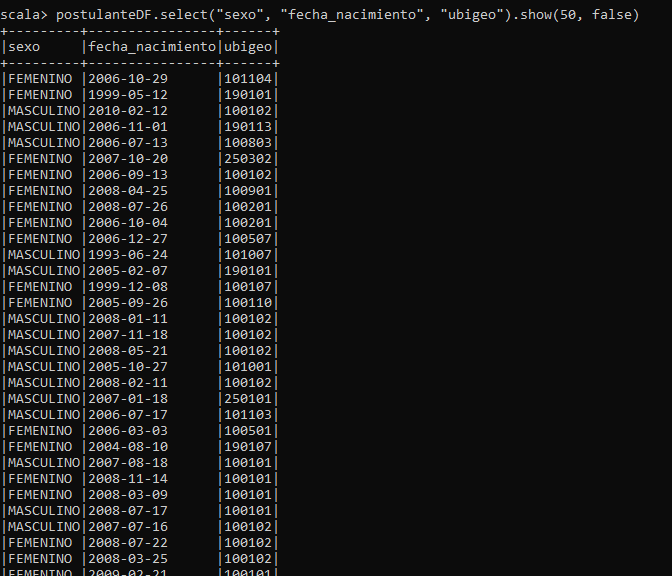



*   ¿Qué facultades y escuelas académicas ofrece la universidad?




In [ ]:
carreraDF_clean.select("facultad", "escuela_academica").show(false)

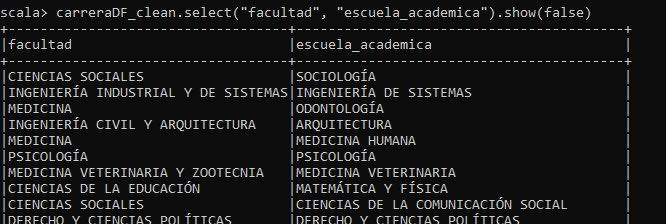

**Uso del comando filter**


*   Postulantes mujeres mayores de 18


In [ ]:
postulanteDF.filter($"sexo" === "FEMENINO" && $"edad" > 18).show(false)

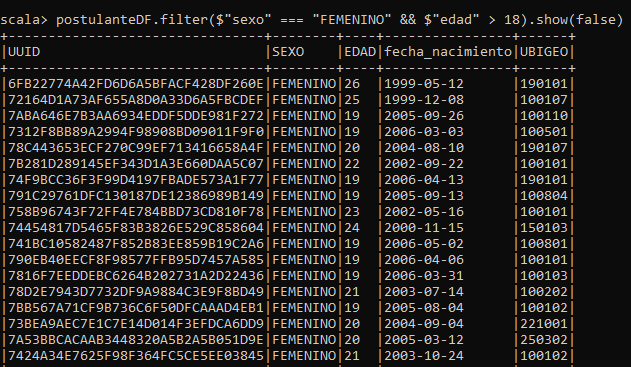



*   Postulantes que NO ALCANZARON VACANTE



In [ ]:
postulacionDF.filter($"situacion".contains("NO ALCANZO VACANTE")).show(50,false)

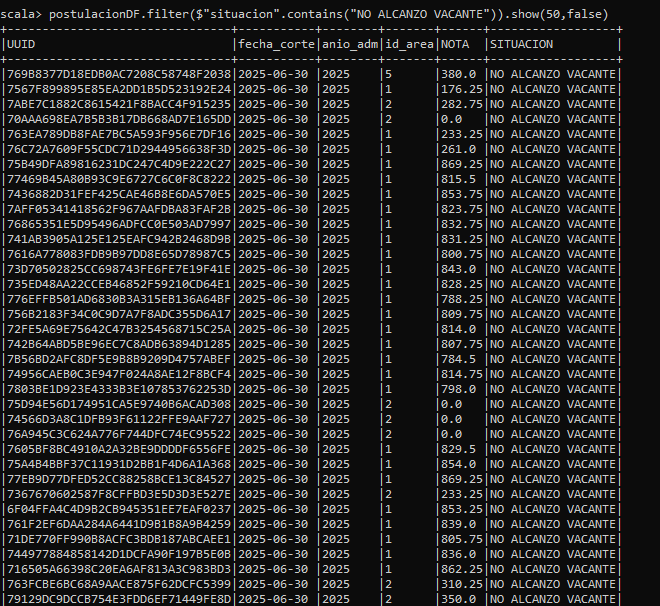

**Mostrar información de la/las tablas ordenadas**



*   Ordenar por nota descendente



In [ ]:
postulacionDF.orderBy(desc("NOTA")).show(50, false)

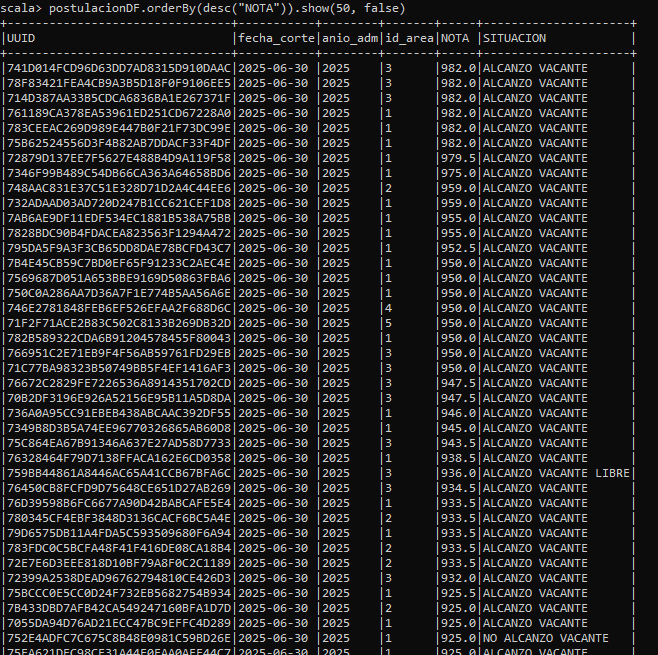

PostulacionDF tiene una fila por postulante, no una fila por cada carrera que seleccionó



*   ¿Quiénes son los postulantes con los puntajes más altos y a qué escuela académica y facultad pertenecen?





In [ ]:
postulacionDF.alias("p").
  join(carreraDF_clean.alias("c"), $"p.id_area" === $"c.ID_AREA").
  join(postulanteDF.alias("t"), $"p.uuid" === $"t.uuid").
  select(
      $"t.uuid",
      $"t.sexo",
      $"t.edad",
      $"c.facultad",
      $"c.escuela_academica",
      $"p.nota",
      $"p.situacion"
  ).orderBy($"nota".desc).
  show(50, false)

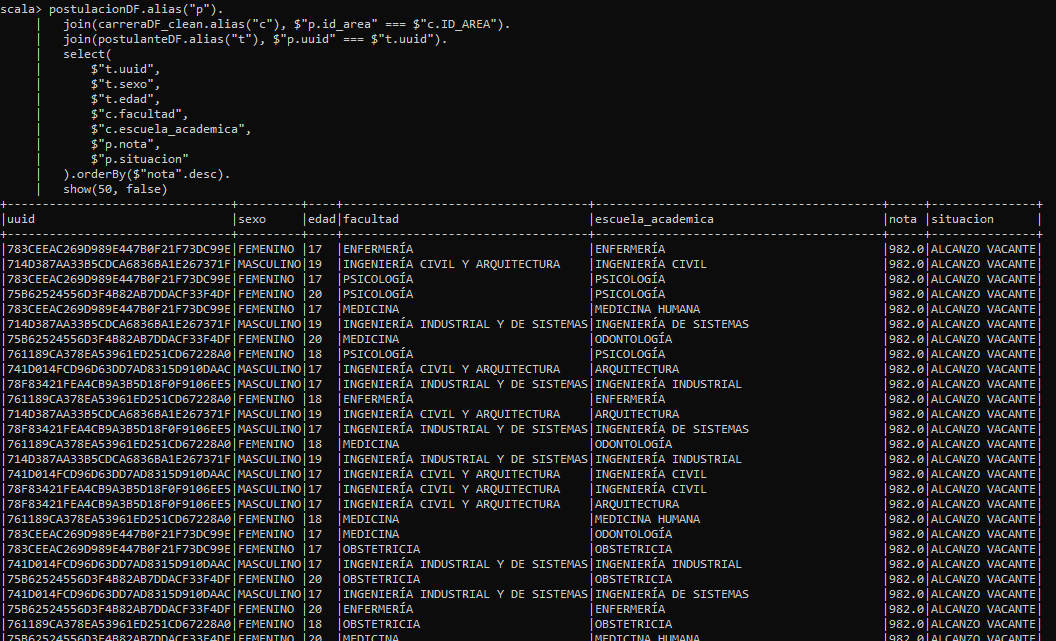

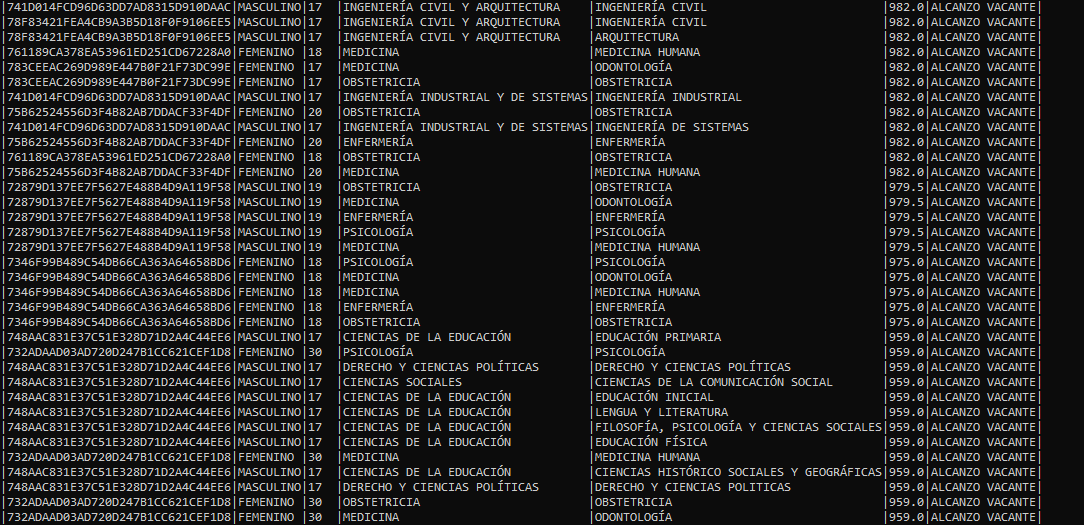

El mismo postulante puede tener 4 postulaciones distintas, todas con la misma nota.

**Utilizar el comando groupBy y count**

¿Qué escuelas académicas reciben la mayor cantidad de postulaciones en el proceso de admisión?

In [ ]:
postulacionDF.alias("p").
  join(carreraDF_clean.alias("c"), $"p.id_area" === $"c.ID_AREA").
  groupBy("escuela_academica").
  count().
  orderBy($"count".desc).show(false)


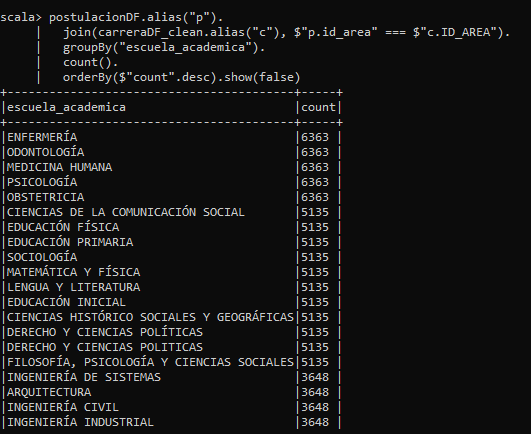

**Una consulta que incluya el promedio de una columna**



*   Promedio de notas por Area


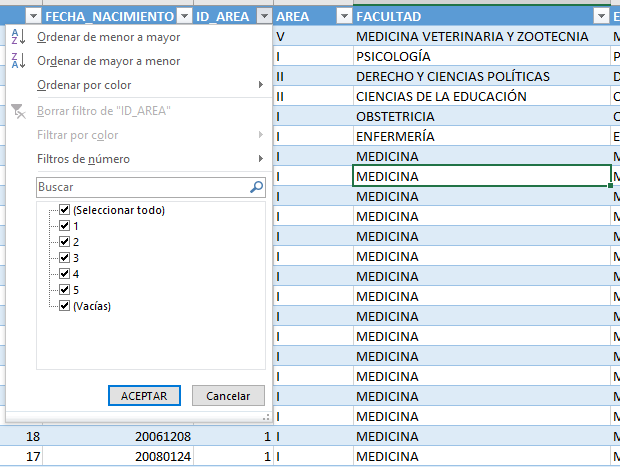

In [ ]:
postulacionDF.groupBy("id_area").agg(avg("nota").as("promedio_notas")).orderBy(desc("promedio_notas")).
  show(false)


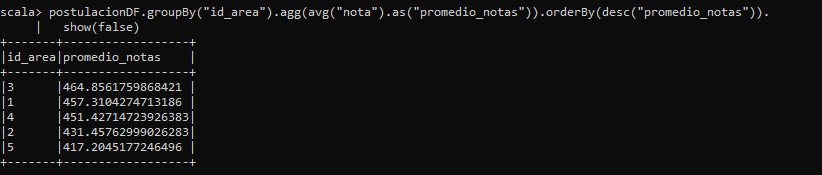

**Consulta que incluya el comando join**



*   Unimos postulante + postulacion



In [ ]:
val join1 = postulanteDF.join(postulacionDF, "uuid")

join1.select("uuid", "sexo", "edad", "nota", "situacion").show(false)

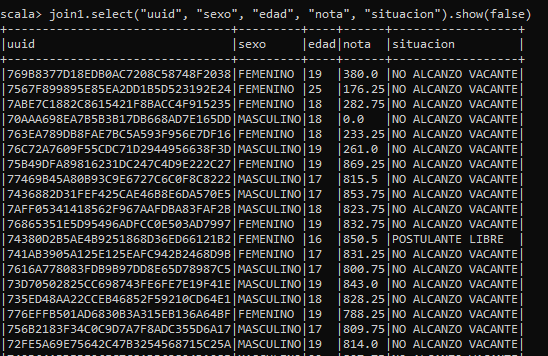



*   Unimos postulante + ubicacion


In [ ]:
val join2 = postulanteDF.join(ubicacionDF_clean, "ubigeo")

join2.show(30, false)

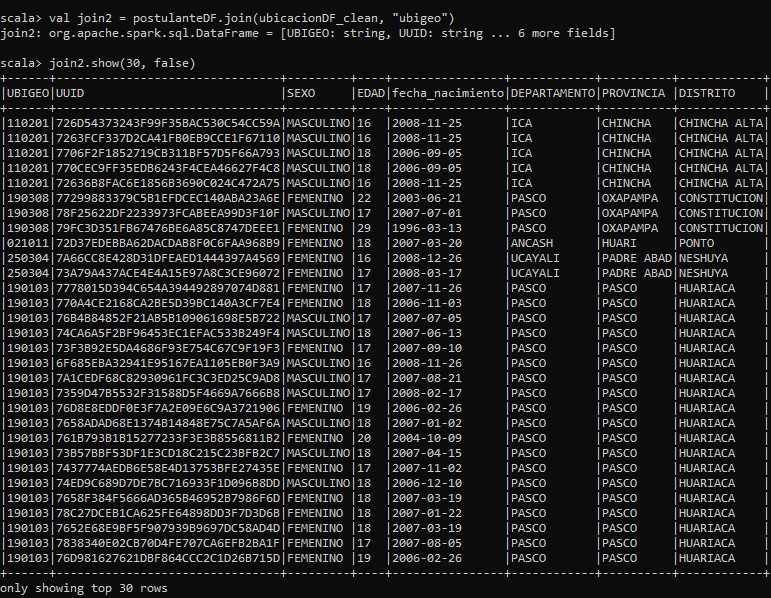



*   Unimos postulante + carrera + proceso



In [ ]:
val fullJoin = postulacionDF.join(postulanteDF, "uuid").
  join(carreraDF_clean, "id_area").
  join(procesoDF_clean, Seq("fecha_corte", "anio_adm"))

fullJoin.show(40, false)


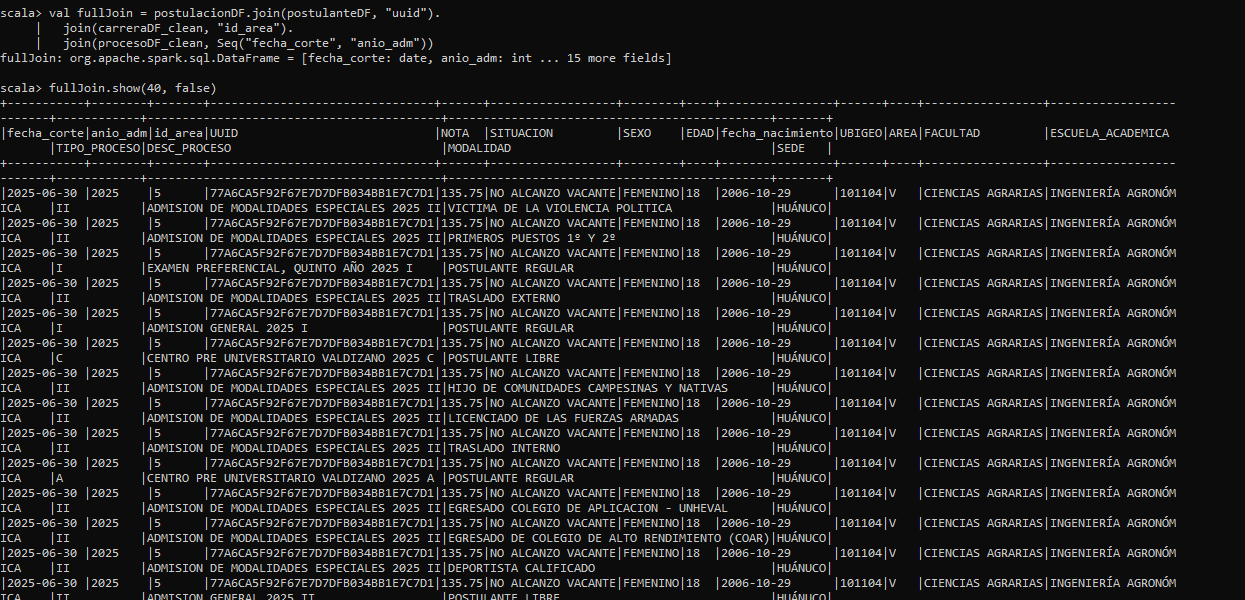

**Consulta utilizando las funciones de org.apache.spark.sql.functions._**




*   creamos columna CONCAT (Departamento + Provincia)



In [ ]:
ubicacionDF_clean.select(
  $"ubigeo",
  concat_ws(" - ", $"departamento", $"provincia", $"distrito").as("ubicacion_completa")
).show(false)


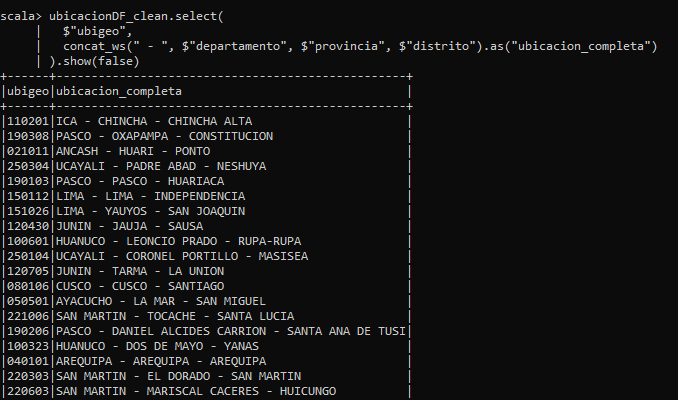



*  contar postulantes por departamento



In [ ]:
postulanteDF.join(ubicacionDF_clean, "ubigeo").
  groupBy("departamento").
  agg(count("*").as("total_postulantes")).
  orderBy(desc("total_postulantes")).
  show(false)


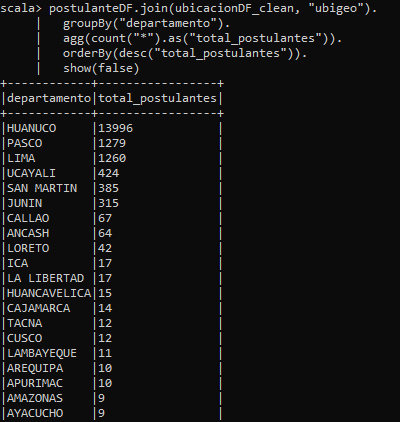

# Utilizando Vistas temporales y SQL hacer consultas de:

**Creamos las siguientes vistas temporales en Spark**

In [ ]:
postulanteDF.createOrReplaceTempView("postulante")
ubicacionDF_clean.createOrReplaceTempView("ubicacion")
carreraDF_clean.createOrReplaceTempView("carrera")
procesoDF_clean.createOrReplaceTempView("proceso")
postulacionDF.createOrReplaceTempView("postulacion")

**1 Selección utilizando join.**

Datos completos del postulante

In [ ]:
spark.sql("""
SELECT
  p.uuid,
  p.sexo,
  p.edad,
  u.departamento,
  c.facultad,
  pr.desc_proceso,
  pr.modalidad,
  ps.nota
FROM postulante p
JOIN postulacion ps ON p.uuid = ps.uuid
JOIN ubicacion u ON p.ubigeo = u.ubigeo
JOIN carrera c ON ps.id_area = c.ID_AREA
JOIN proceso pr ON ps.fecha_corte = pr.fecha_corte
LIMIT 20
""").show(false)


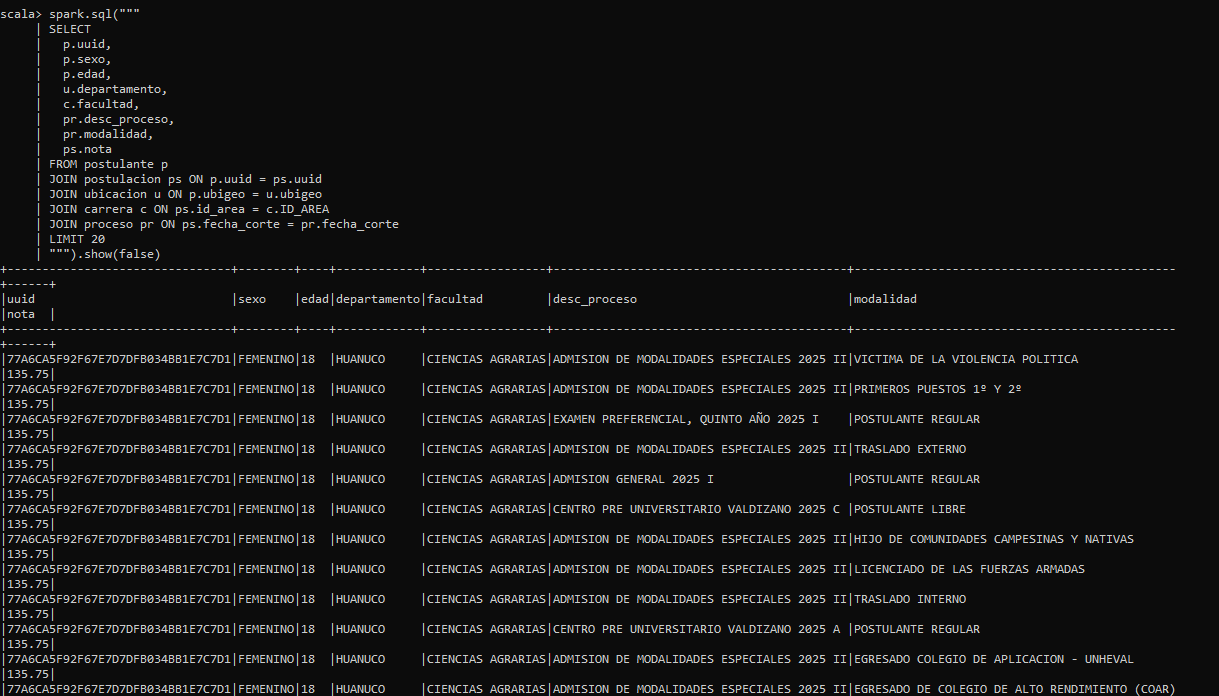

**2) Dos consultas con GROUP BY + COUNT**

Cantidad de postulantes por sexo

In [ ]:
spark.sql("""
SELECT sexo, COUNT(*) AS total
FROM postulante
GROUP BY sexo
""").show()


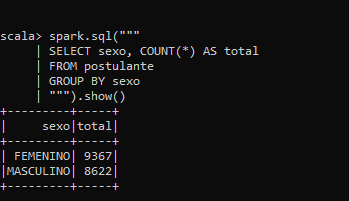

Cantidad de postulantes por facultad

In [ ]:
spark.sql("""
SELECT c.facultad, COUNT(*) AS total
FROM postulante p
JOIN postulacion ps ON p.uuid = ps.uuid
JOIN carrera c ON ps.id_area = c.ID_AREA
GROUP BY c.facultad
ORDER BY total DESC
""").show(false)


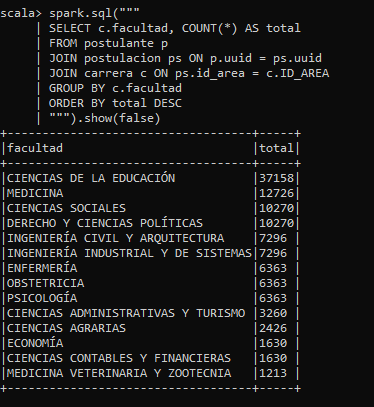

**3) Dos consultas usando ORDER BY + otros operadores**

Top 20 notas más altas

In [ ]:
spark.sql("""
SELECT uuid, nota, situacion
FROM postulacion
ORDER BY nota DESC
LIMIT 20
""").show(false)


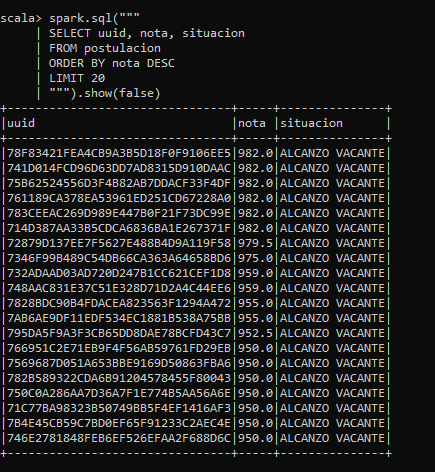

Postulantes ordenados por departamento y nota descendente

In [ ]:
spark.sql("""
SELECT
  p.uuid,
  u.departamento,
  ps.nota,
  ps.situacion
FROM postulante p
JOIN postulacion ps ON p.uuid = ps.uuid
JOIN ubicacion u ON p.ubigeo = u.ubigeo
ORDER BY u.departamento ASC, ps.nota DESC
LIMIT 30
""").show(false)


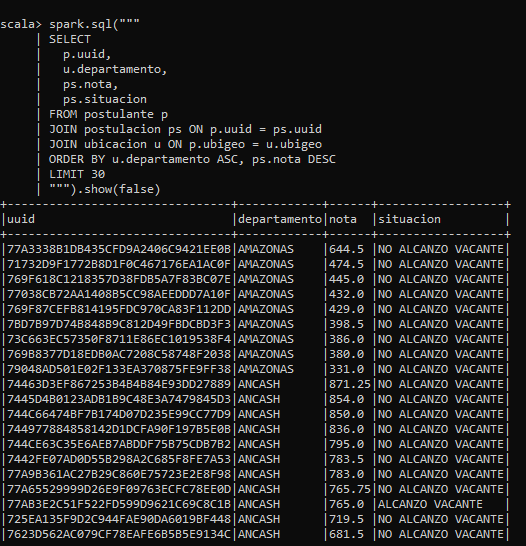